In [35]:
#Importing stuff

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity

In [36]:
#accessing google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [37]:
cd drive/My\Drive

[Errno 2] No such file or directory: 'drive/MyDrive'
/content/drive/MyDrive


In [38]:
#downloading data from csv
StarData = pd.read_csv('StarData.csv')


In [39]:
#defining features and target
featuresns = StarData.drop(['Star type','Star color','Spectral Class'],axis = 1)
target = StarData['Star type']

     Temperature (K)  Luminosity(L/Lo)  Radius(R/Ro)  Absolute magnitude(Mv)
0               3068          0.002400        0.1700                   16.12
1               3042          0.000500        0.1542                   16.60
2               2600          0.000300        0.1020                   18.70
3               2800          0.000200        0.1600                   16.65
4               1939          0.000138        0.1030                   20.06
..               ...               ...           ...                     ...
235            38940     374830.000000     1356.0000                   -9.93
236            30839     834042.000000     1194.0000                  -10.63
237             8829     537493.000000     1423.0000                  -10.73
238             9235     404940.000000     1112.0000                  -11.23
239            37882     294903.000000     1783.0000                   -7.80

[240 rows x 4 columns]


In [40]:
#Scaling the features data
featuresns.to_numpy
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(featuresns)
dataStar = scaler.transform(featuresns)
features = pd.DataFrame(dataStar, columns = ['Temperature (K)','Luminosity(L/Lo)','Radius(R/Ro)','Absolute magnitude(Mv)'])
         


In [41]:
features.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv)
0,-0.779382,-0.598624,-0.459210,1.116745
1,-0.782110,-0.598624,-0.459241,1.162414
2,-0.828477,-0.598624,-0.459342,1.362213
3,-0.807496,-0.598624,-0.459229,1.167171
4,-0.897819,-0.598624,-0.459340,1.491607


In [62]:
target.head()

0    0
1    0
2    0
3    0
4    0
Name: Star type, dtype: int64

In [42]:
#Creating custom estimator from lecture
from sklearn.base import BaseEstimator, ClassifierMixin


class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    
    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
        
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self
        
    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
                             for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

In [43]:
#applying it to my features and target
from sklearn.model_selection import GridSearchCV
np.seterr(invalid='ignore')

bandwidths = 10 ** np.linspace(-5, 1, 100)
grid = GridSearchCV(KDEClassifier(), {'bandwidth': bandwidths})
grid.fit(features, target)

scores = grid.cv_results_['mean_test_score']


{'bandwidth': 0.07564633275546291}
accuracy = 0.9833333333333334


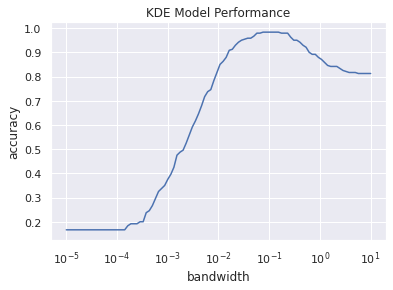

In [44]:
#plotting the KDE Model performance
plt.semilogx(bandwidths, scores)
plt.xlabel('bandwidth')
plt.ylabel('accuracy')
plt.title('KDE Model Performance')
print(grid.best_params_)
print('accuracy =', grid.best_score_)

In [45]:
#what you get using naive bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
cross_val_score(GaussianNB(), features, target).mean()

#naive bayes is probably better in this case because the scatter plots for the stars probably follow some sort of gaussian shape whereas the digits were more messy

0.9916666666666666

In [46]:
#what you get using naive bayes with no scaling
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
cross_val_score(GaussianNB(), featuresns, target).mean()

0.8625

Text(0.5, 1.0, 'Hertzsprung-Russell Diagram')

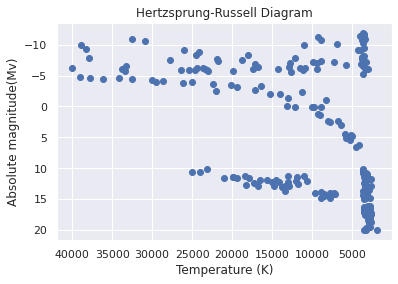

In [51]:
#plotting data from csv file directly 
nstar = StarData.to_numpy()

scatter = plt.scatter(nstar[:,0], nstar[:,3])
ax = scatter.axes
ax.invert_xaxis()
ax.invert_yaxis()

plt.xlabel('Temperature (K)')
plt.ylabel('Absolute magnitude(Mv)')
plt.title('Hertzsprung-Russell Diagram')

In [60]:
#creating new "fake" data using KDE (unscaled version)
params = {"bandwidth": np.logspace(-2, 0, 20)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(featuresns)

print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

kde = grid.best_estimator_

new_data = kde.sample(230, random_state=0)

best bandwidth: 1.0


Text(0.5, 1.0, 'Hertzsprung-Russell Diagram')

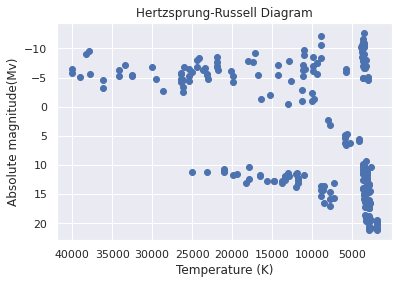

In [61]:
#Plotting new data generated from KDE
scatter = plt.scatter((new_data)[:,0], (new_data)[:,3])
ax = scatter.axes
ax.invert_xaxis()
ax.invert_yaxis()

plt.xlabel('Temperature (K)')
plt.ylabel('Absolute magnitude(Mv)')
plt.title('Hertzsprung-Russell Diagram')